Installing the required libraries

In [ ]:
!pip install autogluon numpy  scikit-learn matplotlib pandas

In [ ]:
!pip install -U torch torchaudio --no-cache-dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CV ERA CATUR INTELIGENSIA/trainings/cloud n genAI/codes/Data-Analytics-with-GenAI/Module_3
%pwd

Importing libraries and load AirPassenger Data set.

In [ ]:
import autogluon
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.models import WaveNetModel
import pandas as pd

# To load local csv  > modify to the right path where the file is present
Y_df = pd.read_csv('./data/AirPassengersDataset.csv')
Y_df = Y_df.reset_index(drop=True)
Y_df.head()


,unique_id,ds,y
0,1,31-01-49,112
1,1,28-02-49,118
2,1,31-03-49,132
3,1,30-04-49,129
4,1,31-05-49,121


Define calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Converting date field to datetime format and renaming columns to required format

In [ ]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.rename(columns={"ds":"timestamp","unique_id" :"item_id", "y": "target"},inplace = True)
Y_df['item_id'] = 'airline_1'
Y_df.head()

/tmp/ipython-input-6-3280510512.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Y_df['ds'] = pd.to_datetime(Y_df['ds'])


,item_id,timestamp,target
0,airline_1,2049-01-31,112
1,airline_1,2049-02-28,118
2,airline_1,2049-03-31,132
3,airline_1,2049-04-30,129
4,airline_1,2049-05-31,121


AutoGluon expects time series data in long format. Each row of the data frame contains a single observation (timestep) of a single time series represented by

unique ID of the time series ("**item_id**") as int or str

timestamp of the observation ("**timestamp**") as a pandas.Timestamp or compatible format

numeric value of the time series ("**target**")

In [ ]:
data = TimeSeriesDataFrame.from_data_frame(
    Y_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
data.tail()

target
item_id   timestamp         
airline_1 2060-08-31     606
          2060-09-30     508
          2060-10-31     461
          2060-11-30     390
          2060-12-31     432

Split data into **train** and **test**

In [ ]:
train_data = data.head(132)
test_data = data.tail(12)

Create a **TimeSeriesPredictor** object to forecast future values and explicitly define "**chronos_tiny**" to be used

In [ ]:
prediction_length =12
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
train_data, presets="chronos_tiny"
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Colab Notebooks/AutogluonModels/ag-20250619_135939'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       11.15 GB / 12.67 GB (88.0%)
Disk Space Avail:   48.78 GB / 100.00 GB (48.8%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'ME'
Pr

Predict for the next defined horizon

In [ ]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


In [ ]:
predictions

mean         0.1         0.2         0.3  \
item_id   timestamp                                                    
airline_1 2060-01-31  408.364349  388.542694  394.123535  397.779938   
          2060-02-29  413.271637  380.267639  392.968872  400.474152   
          2060-03-31  440.309875  408.749237  421.065582  426.646423   
          2060-04-30  430.880188  401.821228  414.522522  422.797546   
          2060-05-31  460.805084  407.209686  448.777374  456.282654   
          2060-06-30  529.603455  468.983887  496.888153  515.170288   
          2060-07-31  591.858826  552.504211  568.861938  580.985779   
          2060-08-31  571.171204  509.589417  529.988403  550.387329   
          2060-09-30  484.764252  440.694794  459.554199  465.135040   
          2060-10-31  410.866119  381.807190  384.886261  389.504883   
          2060-11-30  377.092346  338.507446  350.631378  361.215759   
          2060-12-31  404.226807  382.384521  384.501373  388.735138   

                             0.4         0.5         0.6         0.7  \
item_id   timestamp                                                    
airline_1 2060-01-31  401.436371  409.903870  414.522522  421.258026   
          2060-02-29  413.752747  416.639404  420.295807  421.450470   
          2060-03-31  431.072601  435.883667  441.464569  447.045410   
          2060-04-30  424.529541  432.997040  440.309875  442.619232   
          2060-05-31  462.633270  470.523438  478.028748  479.183411   
          2060-06-30  523.060425  527.294189  552.311768  554.236206   
          2060-07-31  590.800415  593.687073  596.188843  603.501648   
          2060-08-31  573.865417  586.951538  590.800415  593.302185   
          2060-09-30  479.568298  487.843353  490.345123  495.733521   
          2060-10-31  403.360779  413.752747  419.141144  422.027802   
          2060-11-30  364.102386  369.490814  373.724579  390.467133   
          2060-12-31  394.508423  400.281708  405.670105  412.982971   

                             0.8         0.9  
item_id   timestamp                           
airline_1 2060-01-31  425.684204  429.148193  
          2060-02-29  435.306366  447.237854  
          2060-03-31  466.097260  481.107849  
          2060-04-30  446.852966  467.636810  
          2060-05-31  481.492737  492.077087  
          2060-06-30  560.009521  582.332947  
          2060-07-31  617.742432  635.447266  
          2060-08-31  600.422546  608.120300  
          2060-09-30  508.434784  512.091187  
          2060-10-31  427.993530  448.584961  
          2060-11-30  404.900330  412.213226  
          2060-12-31  431.457489  436.845886

Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data['target'],predictions['mean']['airline_1'])

MSE : 683.2634887695312
RMSE : 26.13930926343562
MAPE : 0.04878978803753853
r2 : 0.8766554594039917
adjusted_r2 : 0.8643210053443908


Visualize the predictions

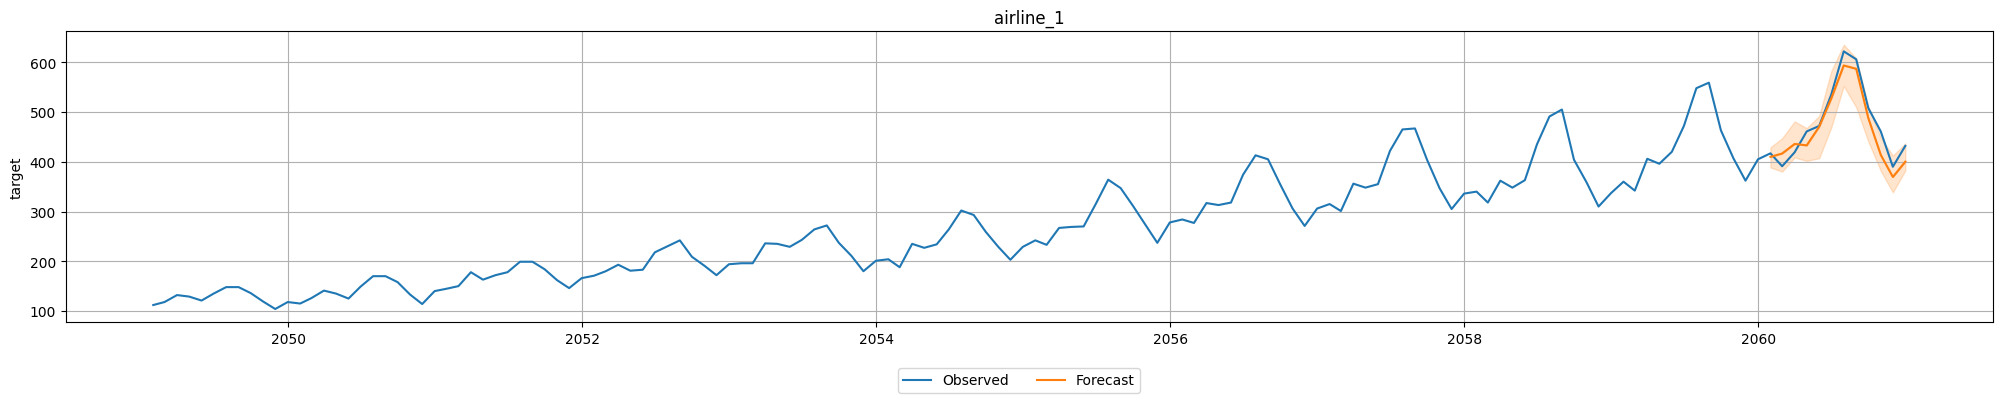

In [ ]:
predictor.plot(
    data=Y_df,
    predictions=predictions,
    item_ids=["airline_1"],
    max_history_length=200,
);